In [10]:
import pandas as pd
import string
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import unicodedata
from sklearn.linear_model import RidgeCV
import numpy as np
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import shap
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from scikeras.wrappers import KerasRegressor
import xgboost as xgb
import tensorflow as tf
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

In [2]:
X_train = pd.read_csv('/Users/emilfalk/Desktop/X_train.csv')
X_test = pd.read_csv('/Users/emilfalk/Desktop/X_test.csv')
y_train = pd.read_csv('/Users/emilfalk/Desktop/y_train.csv')
y_test = pd.read_csv('/Users/emilfalk/Desktop/y_test.csv')

In [3]:
fp_mean = X_train['FP'].mean()

X_train['FP'] = fp_mean
X_test['FP'] = fp_mean

In [4]:
player_names = X_test['Player']

In [5]:
X_train = X_train.drop(columns=['Player']) 
X_test = X_test.drop(columns=['Player']) 

In [6]:
X_train_basketball = X_train.drop(['years_with_team', 'draft_pos', 'all_star', 'num_teams', 'ig_followers', 'resigned', 'Agent'], axis=1)
X_test_basketball = X_test.drop(['years_with_team', 'draft_pos', 'all_star', 'num_teams', 'ig_followers', 'resigned', 'Agent'], axis=1)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)
basketball_scaler = StandardScaler()
X_train_basketball_scaled = basketball_scaler.fit_transform(X_train_basketball) 
X_test_basketball_scaled = basketball_scaler.transform(X_test_basketball)

In [8]:
X_train_scaled_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
X_train_basketball_scaled_cnn = X_train_basketball_scaled.reshape(X_train_basketball_scaled.shape[0], X_train_basketball_scaled.shape[1], 1)
X_test_basketball_scaled_cnn = X_test_basketball_scaled.reshape(X_test_basketball_scaled.shape[0], X_test_basketball_scaled.shape[1], 1)

## Inspection

In [15]:
pd.set_option('display.float_format', '{:.2f}'.format)
y_train.describe()

,Salary
count,354.00
mean,8415441.36
std,10152411.94
min,19186.00
25%,1782621.00
50%,4000000.00
75%,11539524.50
max,45780966.00


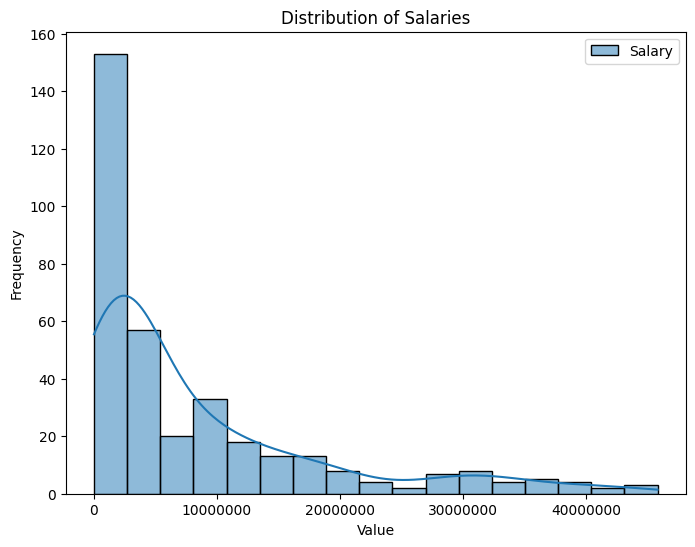

In [21]:
plt.figure(figsize=(8, 6))
sns.histplot(y_train, kde=True)
plt.title('Distribution of Salaries')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.ticklabel_format(style='plain', axis='x')
plt.show()

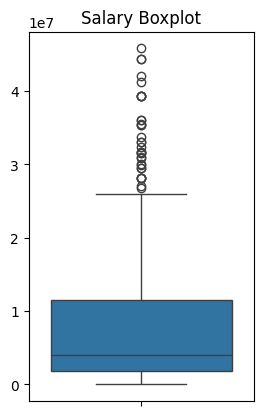

In [124]:
plt.subplot(1, 2, 2)
sns.boxplot(y=y_train_values)
plt.title('Salary Boxplot')
plt.show()

In [123]:
y_train_values = y_train.values.flatten() if isinstance(y_train, pd.DataFrame) else y_train

Q1 = np.percentile(y_train_values, 25)
Q3 = np.percentile(y_train_values, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = y_train_values[(y_train_values < lower_bound) | (y_train_values > upper_bound)]
print("Number of outliers:", len(outliers))
print("Outlier values:", outliers)

Number of outliers: 34
Outlier values: [44310840 29925000 28103500 32405817 26758928 30864198 31650600 26984128
 33724200 29467800 31579390 31650600 44310840 31579390 39344900 28103500
 36016200 28103500 33003936 45780966 39344970 35500000 35328700 30013500
 33003936 42018900 39344900 41180544 35344828 31044906 28103500 39344900
 29467800 35995950]


## Multiple Linear Regression

In [31]:
np.random.seed(42)
mlr = LinearRegression()

results = []

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set):
    model.fit(X_train, y_train.values.ravel())  
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': 'Linear Regression',
        'Feature Set': feature_set,
        'Dataset': 'Test',
        'MAE': test_mae,
        'R2': test_r2
    })
    
    return model

mlr_basketball = evaluate_model(mlr, X_train_basketball_scaled, X_test_basketball_scaled, y_train, y_test, 'Basketball Features')
mlr_full = evaluate_model(mlr, X_train_scaled, X_test_scaled, y_train, y_test, 'Non-Basketball Features')

results_df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.4f}'.format) 

print("\nLinear Regression Results:")
print(results_df)


Linear Regression Results:
               Model              Feature Set Dataset          MAE     R2
0  Linear Regression      Basketball Features    Test 4210336.7310 0.6694
1  Linear Regression  Non-Basketball Features    Test 3722742.0626 0.7482


## Ridge Regression

In [42]:
ridge = Ridge(random_state=42)

param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

results = []

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set):
    model.fit(X_train, y_train.values.ravel())  
    
    y_test_pred = model.predict(X_test)
    
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': 'Ridge Regression',
        'Feature Set': feature_set,
        'Dataset': 'Test',
        'MAE': test_mae,
        'R2': test_r2
    })
    
    return model

grid_search_basketball = GridSearchCV(ridge, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_basketball.fit(X_train_basketball_scaled, y_train.values.ravel())
ridge_basketball = evaluate_model(grid_search_basketball.best_estimator_, 
                                 X_train_basketball_scaled, X_test_basketball_scaled, 
                                 y_train, y_test, 'Basketball Features')
print(f"Best Ridge alpha (Basketball Features): {grid_search_basketball.best_params_['alpha']}")

grid_search_full = GridSearchCV(ridge, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_full.fit(X_train_scaled, y_train.values.ravel())
ridge_full = evaluate_model(grid_search_full.best_estimator_, 
                           X_train_scaled, X_test_scaled, 
                           y_train, y_test, 'Non-Basketball Features')
print(f"Best Ridge alpha (Non-Basketball Features): {grid_search_full.best_params_['alpha']}")

results_df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.4f}'.format) 

print("\nRidge Regression Results:")
print(results_df)

Best Ridge alpha (Basketball Features): 100.0
Best Ridge alpha (Non-Basketball Features): 100.0

Ridge Regression Results:
              Model              Feature Set Dataset          MAE     R2
0  Ridge Regression      Basketball Features    Test 4197284.3360 0.6927
1  Ridge Regression  Non-Basketball Features    Test 3747815.8138 0.7522


## Lasso Regression

In [50]:
lasso = Lasso(random_state=42)

param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

results = []

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set):
    model.fit(X_train, y_train.values.ravel())  
    
    y_test_pred = model.predict(X_test)
    
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': 'Lasso Regression',
        'Feature Set': feature_set,
        'Dataset': 'Test',
        'MAE': test_mae,
        'R2': test_r2
    })
    
    return model

grid_search_basketball = GridSearchCV(lasso, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_basketball.fit(X_train_basketball_scaled, y_train.values.ravel())
lasso_basketball = evaluate_model(grid_search_basketball.best_estimator_, 
                                 X_train_basketball_scaled, X_test_basketball_scaled, 
                                 y_train, y_test, 'Basketball Features')
print(f"Best Lasso alpha (Basketball Features): {grid_search_basketball.best_params_['alpha']}")

grid_search_full = GridSearchCV(lasso, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_full.fit(X_train_scaled, y_train.values.ravel())
lasso_full = evaluate_model(grid_search_full.best_estimator_, 
                           X_train_scaled, X_test_scaled, 
                           y_train, y_test, 'Non-Basketball Features')
print(f"Best Lasso alpha (Non-Basketball Features): {grid_search_full.best_params_['alpha']}")

results_df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.4f}'.format)  

print("\nLasso Regression Results:")
print(results_df)

Best Lasso alpha (Basketball Features): 100.0
Best Lasso alpha (Non-Basketball Features): 100.0

Lasso Regression Results:
              Model              Feature Set Dataset          MAE     R2
0  Lasso Regression      Basketball Features    Test 4184810.5377 0.6737
1  Lasso Regression  Non-Basketball Features    Test 3684783.1455 0.7499


/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.304e+15, tolerance: 2.977e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.305e+15, tolerance: 2.756e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

## Decision Tree

In [51]:
dt = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10]
}

results = []

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set):
    model.fit(X_train, y_train.values.ravel())  
    
    y_test_pred = model.predict(X_test)
    
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': 'Decision Tree Regression',
        'Feature Set': feature_set,
        'Dataset': 'Test',
        'MAE': test_mae,
        'R2': test_r2
    })
    
    return model

grid_search_basketball = GridSearchCV(dt, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_basketball.fit(X_train_basketball_scaled, y_train.values.ravel())
dt_basketball = evaluate_model(grid_search_basketball.best_estimator_, 
                              X_train_basketball_scaled, X_test_basketball_scaled, 
                              y_train, y_test, 'Basketball Features')
print(f"Best Decision Tree params (Basketball Features): {grid_search_basketball.best_params_}")

grid_search_full = GridSearchCV(dt, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_full.fit(X_train_scaled, y_train.values.ravel())
dt_full = evaluate_model(grid_search_full.best_estimator_, 
                        X_train_scaled, X_test_scaled, 
                        y_train, y_test, 'Non-Basketball Features')
print(f"Best Decision Tree params (Non-Basketball Features): {grid_search_full.best_params_}")

results_df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.4f}'.format)  

print("\nDecision Tree Regression Results:")
print(results_df)

Best Decision Tree params (Basketball Features): {'max_depth': 5, 'min_samples_split': 5}
Best Decision Tree params (Non-Basketball Features): {'max_depth': 3, 'min_samples_split': 10}

Decision Tree Regression Results:
                      Model              Feature Set Dataset          MAE  \
0  Decision Tree Regression      Basketball Features    Test 3617525.2017   
1  Decision Tree Regression  Non-Basketball Features    Test 3262377.8422   

      R2  
0 0.6441  
1 0.7485  


## Random Forest

In [133]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None]
}

results = []

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set):
    model.fit(X_train, y_train.values.ravel())  
    
    y_test_pred = model.predict(X_test)
    
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': 'Random Forest Regression',
        'Feature Set': feature_set,
        'Dataset': 'Test',
        'MAE': test_mae,
        'R2': test_r2
    })
    
    return model

grid_search_basketball = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_basketball.fit(X_train_basketball_scaled, y_train.values.ravel())
rf_basketball = evaluate_model(grid_search_basketball.best_estimator_, 
                              X_train_basketball_scaled, X_test_basketball_scaled, 
                              y_train, y_test, 'Basketball Features')
print(f"Best Random Forest params (Basketball Features): {grid_search_basketball.best_params_}")

grid_search_full = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_full.fit(X_train_scaled, y_train.values.ravel())
rf_full = evaluate_model(grid_search_full.best_estimator_, 
                        X_train_scaled, X_test_scaled, 
                        y_train, y_test, 'Non-Basketball Features')
print(f"Best Random Forest params (Non-Basketball Features): {grid_search_full.best_params_}")

results_df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.4f}'.format)  

print("\nRandom Forest Regression Results:")
print(results_df)

Best Random Forest params (Basketball Features): {'max_depth': 10, 'n_estimators': 200}
Best Random Forest params (Non-Basketball Features): {'max_depth': 5, 'n_estimators': 200}

Random Forest Regression Results:
                      Model              Feature Set Dataset          MAE  \
0  Random Forest Regression      Basketball Features    Test 3291131.3222   
1  Random Forest Regression  Non-Basketball Features    Test 2965484.4318   

      R2  
0 0.7580  
1 0.8089  


## XGBoost

In [12]:
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

results = []

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set):
    model.fit(X_train, y_train.values.ravel())  
    
    y_test_pred = model.predict(X_test)
    
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': 'XGBoost Regression',
        'Feature Set': feature_set,
        'Dataset': 'Test',
        'MAE': test_mae,
        'R2': test_r2
    })
    
    return model

grid_search_basketball = GridSearchCV(xgb, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_basketball.fit(X_train_basketball_scaled, y_train.values.ravel())
xgb_basketball = evaluate_model(grid_search_basketball.best_estimator_, 
                               X_train_basketball_scaled, X_test_basketball_scaled, 
                               y_train, y_test, 'Basketball Features')
print(f"Best XGBoost params (Basketball Features): {grid_search_basketball.best_params_}")

grid_search_full = GridSearchCV(xgb, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_full.fit(X_train_scaled, y_train.values.ravel())
xgb_full = evaluate_model(grid_search_full.best_estimator_, 
                         X_train_scaled, X_test_scaled, 
                         y_train, y_test, 'Non-Basketball Features')
print(f"Best XGBoost params (Non-Basketball Features): {grid_search_full.best_params_}")

results_df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.4f}'.format)

print("\nXGBoost Regression Results:")
print(results_df)

Best XGBoost params (Basketball Features): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best XGBoost params (Non-Basketball Features): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

XGBoost Regression Results:
                Model              Feature Set Dataset          MAE     R2
0  XGBoost Regression      Basketball Features    Test 3663381.0957 0.6868
1  XGBoost Regression  Non-Basketball Features    Test 3280486.3362 0.7475


## Multilayer Perceptron

In [70]:
mlp = MLPRegressor(random_state=42, max_iter=1000)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'learning_rate_init': [0.001, 0.01]
}

results = []

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set):
    model.fit(X_train, y_train.values.ravel())  
    
    y_test_pred = model.predict(X_test)
    
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': 'MLP Regression',
        'Feature Set': feature_set,
        'Dataset': 'Test',
        'MAE': test_mae,
        'R2': test_r2
    })
    
    return model

grid_search_basketball = GridSearchCV(mlp, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_basketball.fit(X_train_basketball_scaled, y_train.values.ravel())
mlp_basketball = evaluate_model(grid_search_basketball.best_estimator_, 
                               X_train_basketball_scaled, X_test_basketball_scaled, 
                               y_train, y_test, 'Basketball Features')
print(f"Best MLP params (Basketball Features): {grid_search_basketball.best_params_}")

grid_search_full = GridSearchCV(mlp, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_full.fit(X_train_scaled, y_train.values.ravel())
mlp_full = evaluate_model(grid_search_full.best_estimator_, 
                         X_train_scaled, X_test_scaled, 
                         y_train, y_test, 'Non-Basketball Features')
print(f"Best MLP params (Non-Basketball Features): {grid_search_full.best_params_}")

results_df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.4f}'.format) 

print("\nMLP Regression Results:")
print(results_df)

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa

Best MLP params (Basketball Features): {'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01}


/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa

Best MLP params (Non-Basketball Features): {'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01}

MLP Regression Results:
            Model              Feature Set Dataset          MAE     R2
0  MLP Regression      Basketball Features    Test 3436726.6366 0.7232
1  MLP Regression  Non-Basketball Features    Test 3380124.7992 0.7316


/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


## 1D CNN

In [97]:
np.random.seed(42)
tf.random.set_seed(42)

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
X_train_basketball_scaled = X_train_basketball_scaled.reshape(X_train_basketball_scaled.shape[0], X_train_basketball_scaled.shape[1], 1)
X_test_basketball_scaled = X_test_basketball_scaled.reshape(X_test_basketball_scaled.shape[0], X_test_basketball_scaled.shape[1], 1)

print(f"Full feature set shape: {X_train_scaled.shape}")
print(f"Basketball feature set shape: {X_train_basketball_scaled.shape}")
print(f"y_train shape: {y_train.shape}")

def create_cnn_model(learning_rate=0.001, l2_reg=0.01, dropout_rate_1=0.2, 
                     dropout_rate_2=0.2, dropout_rate_3=0.3, filters_1=32, 
                     filters_2=16, dense_units=50, input_dim=None):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=filters_1, kernel_size=3, activation='relu', 
                              input_shape=(input_dim, 1), padding='same'),
        tf.keras.layers.Dropout(dropout_rate_1),
        tf.keras.layers.Conv1D(filters=filters_2, kernel_size=3, activation='relu', 
                              padding='same'),
        tf.keras.layers.Dropout(dropout_rate_2),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(dense_units, activation='relu', 
                             kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate_3),
        tf.keras.layers.Dense(1)  
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

results = []

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set):
    try:
        model.fit(X_train, y_train.values.ravel())
        y_test_pred = model.predict(X_test)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        results.append({
            'Model': '1D CNN Regression',
            'Feature Set': feature_set,
            'Dataset': 'Test',
            'MAE': test_mae,
            'R2': test_r2
        })
    except Exception as e:
        print(f"Error evaluating model for {feature_set}: {e}")
        results.append({
            'Model': '1D CNN Regression',
            'Feature Set': feature_set,
            'Dataset': 'Test',
            'MAE': np.nan,
            'R2': np.nan
        })
    return model

param_dist = {
    'model__learning_rate': uniform(1e-5, 1e-3),  
    'model__l2_reg': uniform(0.01, 0.1),         
    'model__dropout_rate_1': uniform(0.2, 0.4),  
    'model__dropout_rate_2': uniform(0.2, 0.4), 
    'model__dropout_rate_3': uniform(0.3, 0.4),  
    'model__filters_1': randint(16, 64),        
    'model__filters_2': randint(8, 32),         
    'model__dense_units': randint(20, 100),     
    'batch_size': [8, 16, 32]
}

try:
    cnn_basketball = KerasRegressor(
        model=create_cnn_model,
        epochs=50,
        verbose=0,
        input_dim=X_train_basketball_scaled.shape[1]
    )
    grid_search_basketball = RandomizedSearchCV(cnn_basketball, param_dist, n_iter=10, cv=3, 
                                               scoring='r2', n_jobs=1, random_state=42, 
                                               error_score='raise')
    grid_search_basketball.fit(X_train_basketball_scaled, y_train.values.ravel())
    cnn_basketball = evaluate_model(grid_search_basketball.best_estimator_, 
                                   X_train_basketball_scaled, X_test_basketball_scaled, 
                                   y_train, y_test, 'Basketball Features')
    print(f"Best 1D CNN params (Basketball Features): {grid_search_basketball.best_params_}")
except Exception as e:
    print(f"Error in randomized search (Basketball Features): {e}")
    cnn_basketball = None

try:
    cnn_full = KerasRegressor(
        model=create_cnn_model,
        epochs=50,
        verbose=0,
        input_dim=X_train_scaled.shape[1]
    )
    grid_search_full = RandomizedSearchCV(cnn_full, param_dist, n_iter=10, cv=3, 
                                         scoring='r2', n_jobs=1, random_state=42, 
                                         error_score='raise')
    grid_search_full.fit(X_train_scaled, y_train.values.ravel())
    cnn_full = evaluate_model(grid_search_full.best_estimator_, 
                             X_train_scaled, X_test_scaled, 
                             y_train, y_test, 'Non-Basketball Features')
    print(f"Best 1D CNN params (Non-Basketball Features): {grid_search_full.best_params_}")
except Exception as e:
    print(f"Error in randomized search (Non-Basketball Features): {e}")
    cnn_full = None

results_df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.4f}'.format)  

print("\n1D CNN Regression Results:")
print(results_df)

Full feature set shape: (354, 35, 1)
Basketball feature set shape: (354, 28, 1)
y_train shape: (354, 1)


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

Best 1D CNN params (Basketball Features): {'batch_size': 8, 'model__dense_units': 95, 'model__dropout_rate_1': 0.4446612641953124, 'model__dropout_rate_2': 0.20282652208788698, 'model__dropout_rate_3': 0.3092249700165663, 'model__filters_1': 42, 'model__filters_2': 17, 'model__l2_reg': 0.014666566321361544, 'model__learning_rate': 0.0009837555188414592}


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

Best 1D CNN params (Non-Basketball Features): {'batch_size': 8, 'model__dense_units': 95, 'model__dropout_rate_1': 0.4446612641953124, 'model__dropout_rate_2': 0.20282652208788698, 'model__dropout_rate_3': 0.3092249700165663, 'model__filters_1': 42, 'model__filters_2': 17, 'model__l2_reg': 0.014666566321361544, 'model__learning_rate': 0.0009837555188414592}

1D CNN Regression Results:
               Model              Feature Set Dataset          MAE     R2
0  1D CNN Regression      Basketball Features    Test 4922436.1092 0.4263
1  1D CNN Regression  Non-Basketball Features    Test 5224438.3778 0.3983


In [149]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import wilcoxon
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define models with their best hyperparameters
models = [
    {
        'name': 'Linear Regression',
        'model_basketball': LinearRegression(),
        'model_full': LinearRegression()
    },
    {
        'name': 'Ridge Regression',
        'model_basketball': Ridge(alpha=100.0),
        'model_full': Ridge(alpha=100.0)
    },
    {
        'name': 'Lasso Regression',
        'model_basketball': Lasso(alpha=100.0, random_state=42),
        'model_full': Lasso(alpha=100.0, random_state=42)
    },
    {
        'name': 'Decision Tree',
        'model_basketball': DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=42),
        'model_full': DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
    },
    {
        'name': 'Random Forest',
        'model_basketball': RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42),
        'model_full': RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)
    },
    {
        'name': 'XGBoost',
        'model_basketball': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42),
        'model_full': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=200, random_state=42)
    },
    {
        'name': 'MLP',
        'model_basketball': MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, random_state=42, max_iter=1000),
        'model_full': MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, random_state=42, max_iter=1000)
    }
]

# Number of cross-validation folds
cv_folds = 5
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
results = []
alpha = 0.05  # Significance level for Wilcoxon test

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set, model_name):
    # Test set evaluation
    model.fit(X_train, y_train.values.ravel())
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation MAE scores
    mae_folds = []
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold = X_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_train_fold = y_train.iloc[train_idx] if isinstance(y_train, pd.DataFrame) else y_train[train_idx]
        y_val_fold = y_train.iloc[val_idx] if isinstance(y_train, pd.DataFrame) else y_train[val_idx]
        
        model.fit(X_train_fold, y_train_fold.values.ravel() if isinstance(y_train_fold, pd.DataFrame) else y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        mae_folds.append(mean_absolute_error(y_val_fold, y_pred_fold))
    
    # Store results
    results.append({
        'Model': model_name,
        'Feature Set': feature_set,
        'Dataset': 'Test',
        'MAE': test_mae,
        'R2': test_r2,
        'CV MAE Folds': mae_folds,
        'CV MAE Mean': np.mean(mae_folds)
    })
    
    return model, mae_folds

# Evaluate each model
wilcoxon_results = []
for model_info in models:
    name = model_info['name']
    model_basketball = model_info['model_basketball']
    model_full = model_info['model_full']
    
    # Evaluate Basketball Features
    _, mae_basketball_folds = evaluate_model(
        model_basketball, 
        X_train_basketball_scaled, 
        X_test_basketball_scaled, 
        y_train, 
        y_test, 
        'Basketball Features', 
        name
    )
    
    # Evaluate Non-Basketball Features
    _, mae_full_folds = evaluate_model(
        model_full, 
        X_train_scaled, 
        X_test_scaled, 
        y_train, 
        y_test, 
        'Non-Basketball Features', 
        name
    )
    
    # Wilcoxon test on CV MAE scores
    stat_mae, p_value_mae = wilcoxon(mae_basketball_folds, mae_full_folds)
    mae_improved = p_value_mae < alpha and np.mean(mae_full_folds) < np.mean(mae_basketball_folds)
    
    # Store Wilcoxon results
    wilcoxon_results.append({
        'Model': name,
        'MAE Mean (Basketball Features)': np.mean(mae_basketball_folds),
        'MAE Mean (Non-Basketball Features)': np.mean(mae_full_folds),
        'MAE Wilcoxon Stat': stat_mae,
        'MAE p-value': p_value_mae,
        'MAE Improved': 'Yes' if mae_improved else 'No'
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
wilcoxon_df = pd.DataFrame(wilcoxon_results)
pd.set_option('display.float_format', '{:.4f}'.format)

# Print results
print("\nModel Evaluation Results:")
print(results_df[['Model', 'Feature Set', 'Dataset', 'MAE', 'R2', 'CV MAE Folds', 'CV MAE Mean']])

print("\nWilcoxon Test Results for MAE:")
print(wilcoxon_df[['Model', 'MAE Mean (Basketball Features)', 'MAE Mean (Non-Basketball Features)', 
                  'MAE p-value', 'MAE Improved']])

# Highlight models with significant improvements
print("\nModels with Significant MAE Improvements (p < 0.05):")
improved_models = wilcoxon_df[wilcoxon_df['MAE Improved'] == 'Yes']
if not improved_models.empty:
    print(improved_models[['Model', 'MAE Improved']])
else:
    print("No models showed significant MAE improvements.")

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.351e+15, tolerance: 3.638e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e+15, tolerance: 2.844e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre


Model Evaluation Results:
                Model              Feature Set Dataset          MAE     R2  \
0   Linear Regression      Basketball Features    Test 4210336.7310 0.6694   
1   Linear Regression  Non-Basketball Features    Test 3722742.0626 0.7482   
2    Ridge Regression      Basketball Features    Test 4197284.3360 0.6927   
3    Ridge Regression  Non-Basketball Features    Test 3747815.8138 0.7522   
4    Lasso Regression      Basketball Features    Test 4184810.5377 0.6737   
5    Lasso Regression  Non-Basketball Features    Test 3684783.1455 0.7499   
6       Decision Tree      Basketball Features    Test 3617525.2017 0.6441   
7       Decision Tree  Non-Basketball Features    Test 3262377.8422 0.7485   
8       Random Forest      Basketball Features    Test 3291131.3222 0.7580   
9       Random Forest  Non-Basketball Features    Test 2965484.4318 0.8089   
10            XGBoost      Basketball Features    Test 3493630.8841 0.7049   
11            XGBoost  Non-Basketball

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [150]:
wilcoxon_df

,Model,MAE Mean (Basketball Features),MAE Mean (Non-Basketball Features),MAE Wilcoxon Stat,MAE p-value,MAE Improved
0,Linear Regression,4081516.0553,3908233.2207,0.0000,0.0625,No
1,Ridge Regression,3908325.7285,3666120.7148,0.0000,0.0625,No
2,Lasso Regression,4063807.6556,3897063.7863,0.0000,0.0625,No
3,Decision Tree,3862583.5766,3818064.3272,5.0000,0.6250,No
4,Random Forest,3129194.3366,2977631.0018,0.0000,0.0625,No
5,XGBoost,3121727.0620,2854579.7238,1.0000,0.1250,No
6,MLP,3317780.4592,3260145.7121,5.0000,0.6250,No


In [151]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import wilcoxon
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define models with their best hyperparameters
models = [
    {
        'name': 'Linear Regression',
        'model_basketball': LinearRegression(),
        'model_full': LinearRegression()
    },
    {
        'name': 'Ridge Regression',
        'model_basketball': Ridge(alpha=100.0),
        'model_full': Ridge(alpha=100.0)
    },
    {
        'name': 'Lasso Regression',
        'model_basketball': Lasso(alpha=100.0, random_state=42),
        'model_full': Lasso(alpha=100.0, random_state=42)
    },
    {
        'name': 'Decision Tree',
        'model_basketball': DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=42),
        'model_full': DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
    },
    {
        'name': 'Random Forest',
        'model_basketball': RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42),
        'model_full': RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)
    },
    {
        'name': 'XGBoost',
        'model_basketball': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42),
        'model_full': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=200, random_state=42)
    },
    {
        'name': 'MLP',
        'model_basketball': MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, random_state=42, max_iter=1000),
        'model_full': MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, random_state=42, max_iter=1000)
    }
]

# Number of cross-validation folds
cv_folds = 5
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
results = []
alpha = 0.05  # Significance level for Wilcoxon test

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set, model_name):
    # Test set evaluation
    model.fit(X_train, y_train.values.ravel())
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation MAE scores
    mae_folds = []
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold = X_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_train_fold = y_train.iloc[train_idx] if isinstance(y_train, pd.DataFrame) else y_train[train_idx]
        y_val_fold = y_train.iloc[val_idx] if isinstance(y_train, pd.DataFrame) else y_train[val_idx]
        
        model.fit(X_train_fold, y_train_fold.values.ravel() if isinstance(y_train_fold, pd.DataFrame) else y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        mae_folds.append(mean_absolute_error(y_val_fold, y_pred_fold))
    
    # Store results
    results.append({
        'Model': model_name,
        'Feature Set': feature_set,
        'Dataset': 'Test',
        'MAE': test_mae,
        'R2': test_r2,
        'CV MAE Folds': mae_folds,
        'CV MAE Mean': np.mean(mae_folds)
    })
    
    return model, mae_folds

# Evaluate each model and collect MAE scores
wilcoxon_results = []
for model_info in models:
    name = model_info['name']
    model_basketball = model_info['model_basketball']
    model_full = model_info['model_full']
    
    # Evaluate Basketball Features
    _, mae_basketball_folds = evaluate_model(
        model_basketball, 
        X_train_basketball_scaled, 
        X_test_basketball_scaled, 
        y_train, 
        y_test, 
        'Basketball Features', 
        name
    )
    
    # Evaluate Non-Basketball Features
    _, mae_full_folds = evaluate_model(
        model_full, 
        X_train_scaled, 
        X_test_scaled, 
        y_train, 
        y_test, 
        'Non-Basketball Features', 
        name
    )
    
    # Diagnostics: Print MAE scores and differences
    print(f"\nDiagnostics for {name}:")
    print(f"Basketball Features MAE Folds: {mae_basketball_folds}")
    print(f"Non-Basketball Features MAE Folds: {mae_full_folds}")
    print(f"Differences (Non-Basketball - Basketball): {np.array(mae_full_folds) - np.array(mae_basketball_folds)}")
    
    # Wilcoxon test on CV MAE scores
    stat_mae, p_value_mae = wilcoxon(mae_basketball_folds, mae_full_folds)
    mae_improved = p_value_mae < alpha and np.mean(mae_full_folds) < np.mean(mae_basketball_folds)
    
    # Store Wilcoxon results
    wilcoxon_results.append({
        'Model': name,
        'MAE Mean (Basketball Features)': np.mean(mae_basketball_folds),
        'MAE Mean (Non-Basketball Features)': np.mean(mae_full_folds),
        'MAE Wilcoxon Stat': stat_mae,
        'MAE p-value': p_value_mae,
        'MAE Improved': 'Yes' if mae_improved else 'No'
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
wilcoxon_df = pd.DataFrame(wilcoxon_results)
pd.set_option('display.float_format', '{:.4f}'.format)

# Print results
print("\nModel Evaluation Results:")
print(results_df[['Model', 'Feature Set', 'Dataset', 'MAE', 'R2', 'CV MAE Folds', 'CV MAE Mean']])

print("\nWilcoxon Test Results for MAE:")
print(wilcoxon_df[['Model', 'MAE Mean (Basketball Features)', 'MAE Mean (Non-Basketball Features)', 
                  'MAE p-value', 'MAE Improved']])

# Highlight models with significant improvements
print("\nModels with Significant MAE Improvements (p < 0.05):")
improved_models = wilcoxon_df[wilcoxon_df['MAE Improved'] == 'Yes']
if not improved_models.empty:
    print(improved_models[['Model', 'MAE Improved']])
else:
    print("No models showed significant MAE improvements.")


Diagnostics for Linear Regression:
Basketball Features MAE Folds: [3740826.6544753066, 4525841.746212794, 4544173.331069891, 4024244.544214685, 3572494.000443459]
Non-Basketball Features MAE Folds: [3691936.1307729594, 4462166.098131463, 4265792.704575086, 3572444.788938163, 3548826.3809036976]
Differences (Non-Basketball - Basketball): [ -48890.52370235  -63675.64808133 -278380.62649481 -451799.75527652
  -23667.61953976]

Diagnostics for Ridge Regression:
Basketball Features MAE Folds: [3856472.1997101484, 4296475.835153485, 4254339.114513415, 3541549.241317412, 3592792.2520291978]
Non-Basketball Features MAE Folds: [3834568.801955731, 4083235.10228124, 3806456.9753988083, 3099056.8104088404, 3507285.884081273]
Differences (Non-Basketball - Basketball): [ -21903.39775442 -213240.73287224 -447882.13911461 -442492.43090857
  -85506.36794792]

Diagnostics for Lasso Regression:
Basketball Features MAE Folds: [3761498.77580069, 4568600.4538105875, 4476517.21269577, 3947381.2088812203, 35

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.351e+15, tolerance: 3.638e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e+15, tolerance: 2.844e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre


Diagnostics for Random Forest:
Basketball Features MAE Folds: [2908631.7374258246, 3345985.6508251196, 3382798.984135942, 3320501.602502126, 2688053.708187382]
Non-Basketball Features MAE Folds: [2734816.9234012156, 3130814.25209741, 3286862.5251, 3125710.5086939875, 2609950.7999196555]
Differences (Non-Basketball - Basketball): [-173814.81402461 -215171.39872771  -95936.45903594 -194791.09380814
  -78102.90826773]

Diagnostics for XGBoost:
Basketball Features MAE Folds: [3112488.0994718308, 3130537.014524648, 3507065.0669014086, 3287862.0827464787, 2570683.0464285715]
Non-Basketball Features MAE Folds: [2698542.7502200706, 2628868.6285211267, 3238603.2288732394, 3021254.5994718308, 2685629.411941964]
Differences (Non-Basketball - Basketball): [-413945.34925176 -501668.38600352 -268461.83802817 -266607.48327465
  114946.36551339]


/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa


Diagnostics for MLP:
Basketball Features MAE Folds: [2970660.531245668, 3724806.6502319383, 3441613.72742909, 3450227.443510462, 3001593.94381391]
Non-Basketball Features MAE Folds: [3214596.677037668, 3861375.8586355415, 3155835.0684630987, 3183242.9543505115, 2885678.0020070416]
Differences (Non-Basketball - Basketball): [ 243936.145792    136569.2084036  -285778.65896599 -266984.48915995
 -115915.94180687]

Model Evaluation Results:
                Model              Feature Set Dataset          MAE     R2  \
0   Linear Regression      Basketball Features    Test 4210336.7310 0.6694   
1   Linear Regression  Non-Basketball Features    Test 3722742.0626 0.7482   
2    Ridge Regression      Basketball Features    Test 4197284.3360 0.6927   
3    Ridge Regression  Non-Basketball Features    Test 3747815.8138 0.7522   
4    Lasso Regression      Basketball Features    Test 4184810.5377 0.6737   
5    Lasso Regression  Non-Basketball Features    Test 3684783.1455 0.7499   
6       Decis

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [152]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import wilcoxon
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define models with their best hyperparameters
models = [
    {
        'name': 'Linear Regression',
        'model_basketball': LinearRegression(),
        'model_full': LinearRegression()
    },
    {
        'name': 'Ridge Regression',
        'model_basketball': Ridge(alpha=100.0),
        'model_full': Ridge(alpha=100.0)
    },
    {
        'name': 'Lasso Regression',
        'model_basketball': Lasso(alpha=100.0, random_state=42),
        'model_full': Lasso(alpha=100.0, random_state=42)
    },
    {
        'name': 'Decision Tree',
        'model_basketball': DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=42),
        'model_full': DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
    },
    {
        'name': 'Random Forest',
        'model_basketball': RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42),
        'model_full': RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)
    },
    {
        'name': 'XGBoost',
        'model_basketball': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42),
        'model_full': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=200, random_state=42)
    },
    {
        'name': 'MLP',
        'model_basketball': MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, random_state=42, max_iter=1000),
        'model_full': MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, random_state=42, max_iter=1000)
    }
]

# Number of cross-validation folds
cv_folds = 5  # Try cv_folds = 10 for more power
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
results = []
alpha = 0.05  # Significance level
mae_scale = 1_000_000  # Scale MAE for display (does not affect Wilcoxon test)

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set, model_name):
    # Test set evaluation
    model.fit(X_train, y_train.values.ravel())
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation MAE scores
    mae_folds = []
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold = X_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_train_fold = y_train.iloc[train_idx] if isinstance(y_train, pd.DataFrame) else y_train[train_idx]
        y_val_fold = y_train.iloc[val_idx] if isinstance(y_train, pd.DataFrame) else y_train[val_idx]
        
        model.fit(X_train_fold, y_train_fold.values.ravel() if isinstance(y_train_fold, pd.DataFrame) else y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        mae_folds.append(mean_absolute_error(y_val_fold, y_pred_fold))
    
    # Store results (scale MAE for display)
    results.append({
        'Model': model_name,
        'Feature Set': feature_set,
        'Dataset': 'Test',
        'MAE': test_mae / mae_scale,  # Scaled for display
        'R2': test_r2,
        'CV MAE Folds': mae_folds,  # Raw values for Wilcoxon
        'CV MAE Mean': np.mean(mae_folds) / mae_scale  # Scaled for display
    })
    
    return model, mae_folds

# Evaluate each model and collect MAE scores
wilcoxon_results = []
for model_info in models:
    name = model_info['name']
    model_basketball = model_info['model_basketball']
    model_full = model_info['model_full']
    
    # Evaluate Basketball Features
    _, mae_basketball_folds = evaluate_model(
        model_basketball, 
        X_train_basketball_scaled, 
        X_test_basketball_scaled, 
        y_train, 
        y_test, 
        'Basketball Features', 
        name
    )
    
    # Evaluate Non-Basketball Features
    _, mae_full_folds = evaluate_model(
        model_full, 
        X_train_scaled, 
        X_test_scaled, 
        y_train, 
        y_test, 
        'Non-Basketball Features', 
        name
    )
    
    # Diagnostics: Print MAE scores and differences
    print(f"\nDiagnostics for {name}:")
    print(f"Basketball Features MAE Folds: {[f'{mae:.2f}' for mae in mae_basketball_folds]}")
    print(f"Non-Basketball Features MAE Folds: {[f'{mae:.2f}' for mae in mae_full_folds]}")
    differences = np.array(mae_full_folds) - np.array(mae_basketball_folds)
    print(f"Differences (Non-Basketball - Basketball): {[f'{diff:.2f}' for diff in differences]}")
    
    # Wilcoxon test on CV MAE scores
    stat_mae, p_value_mae = wilcoxon(mae_basketball_folds, mae_full_folds)
    mae_improved = p_value_mae < alpha and np.mean(mae_full_folds) < np.mean(mae_basketball_folds)
    
    # Store Wilcoxon results
    wilcoxon_results.append({
        'Model': name,
        'MAE Mean (Basketball Features)': np.mean(mae_basketball_folds),
        'MAE Mean (Non-Basketball Features)': np.mean(mae_full_folds),
        'MAE Wilcoxon Stat': stat_mae,
        'MAE p-value': p_value_mae,
        'MAE Improved': 'Yes' if mae_improved else 'No'
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
wilcoxon_df = pd.DataFrame(wilcoxon_results)
pd.set_option('display.float_format', '{:.4f}'.format)

# Print results
print("\nModel Evaluation Results:")
print(results_df[['Model', 'Feature Set', 'Dataset', 'MAE', 'R2', 'CV MAE Folds', 'CV MAE Mean']])

print("\nWilcoxon Test Results for MAE:")
print(wilcoxon_df[['Model', 'MAE Mean (Basketball Features)', 'MAE Mean (Non-Basketball Features)', 
                  'MAE p-value', 'MAE Improved']])

# Highlight models with significant improvements
print("\nModels with Significant MAE Improvements (p < 0.05):")
improved_models = wilcoxon_df[wilcoxon_df['MAE Improved'] == 'Yes']
if not improved_models.empty:
    print(improved_models[['Model', 'MAE Improved']])
else:
    print("No models showed significant MAE improvements.")

# Target variable diagnostics
print("\nTarget Variable Diagnostics:")
print("y_train stats:", y_train.describe())
print("y_test stats:", y_test.describe())


Diagnostics for Linear Regression:
Basketball Features MAE Folds: ['3740826.65', '4525841.75', '4544173.33', '4024244.54', '3572494.00']
Non-Basketball Features MAE Folds: ['3691936.13', '4462166.10', '4265792.70', '3572444.79', '3548826.38']
Differences (Non-Basketball - Basketball): ['-48890.52', '-63675.65', '-278380.63', '-451799.76', '-23667.62']

Diagnostics for Ridge Regression:
Basketball Features MAE Folds: ['3856472.20', '4296475.84', '4254339.11', '3541549.24', '3592792.25']
Non-Basketball Features MAE Folds: ['3834568.80', '4083235.10', '3806456.98', '3099056.81', '3507285.88']
Differences (Non-Basketball - Basketball): ['-21903.40', '-213240.73', '-447882.14', '-442492.43', '-85506.37']


/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.351e+15, tolerance: 3.638e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e+15, tolerance: 2.844e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre


Diagnostics for Lasso Regression:
Basketball Features MAE Folds: ['3761498.78', '4568600.45', '4476517.21', '3947381.21', '3565040.63']
Non-Basketball Features MAE Folds: ['3708721.84', '4512573.12', '4257993.62', '3495448.90', '3510581.45']
Differences (Non-Basketball - Basketball): ['-52776.94', '-56027.33', '-218523.60', '-451932.31', '-54459.17']

Diagnostics for Decision Tree:
Basketball Features MAE Folds: ['4020540.05', '4178112.64', '4118793.58', '4463997.06', '2531474.55']
Non-Basketball Features MAE Folds: ['3601064.04', '3671415.94', '3790473.79', '3752321.18', '4275046.69']
Differences (Non-Basketball - Basketball): ['-419476.01', '-506696.70', '-328319.79', '-711675.88', '1743572.13']

Diagnostics for Random Forest:
Basketball Features MAE Folds: ['2908631.74', '3345985.65', '3382798.98', '3320501.60', '2688053.71']
Non-Basketball Features MAE Folds: ['2734816.92', '3130814.25', '3286862.53', '3125710.51', '2609950.80']
Differences (Non-Basketball - Basketball): ['-173814

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa


Diagnostics for MLP:
Basketball Features MAE Folds: ['2970660.53', '3724806.65', '3441613.73', '3450227.44', '3001593.94']
Non-Basketball Features MAE Folds: ['3214596.68', '3861375.86', '3155835.07', '3183242.95', '2885678.00']
Differences (Non-Basketball - Basketball): ['243936.15', '136569.21', '-285778.66', '-266984.49', '-115915.94']

Model Evaluation Results:
                Model              Feature Set Dataset    MAE     R2  \
0   Linear Regression      Basketball Features    Test 4.2103 0.6694   
1   Linear Regression  Non-Basketball Features    Test 3.7227 0.7482   
2    Ridge Regression      Basketball Features    Test 4.1973 0.6927   
3    Ridge Regression  Non-Basketball Features    Test 3.7478 0.7522   
4    Lasso Regression      Basketball Features    Test 4.1848 0.6737   
5    Lasso Regression  Non-Basketball Features    Test 3.6848 0.7499   
6       Decision Tree      Basketball Features    Test 3.6175 0.6441   
7       Decision Tree  Non-Basketball Features    Test 

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [153]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import ttest_rel
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define models with their best hyperparameters
models = [
    {
        'name': 'Linear Regression',
        'model_basketball': LinearRegression(),
        'model_full': LinearRegression()
    },
    {
        'name': 'Ridge Regression',
        'model_basketball': Ridge(alpha=100.0),
        'model_full': Ridge(alpha=100.0)
    },
    {
        'name': 'Lasso Regression',
        'model_basketball': Lasso(alpha=100.0, random_state=42),
        'model_full': Lasso(alpha=100.0, random_state=42)
    },
    {
        'name': 'Decision Tree',
        'model_basketball': DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=42),
        'model_full': DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
    },
    {
        'name': 'Random Forest',
        'model_basketball': RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42),
        'model_full': RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)
    },
    {
        'name': 'XGBoost',
        'model_basketball': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42),
        'model_full': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=200, random_state=42)
    },
    {
        'name': 'MLP',
        'model_basketball': MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, random_state=42, max_iter=1000),
        'model_full': MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, random_state=42, max_iter=1000)
    }
]

# Number of cross-validation folds
cv_folds = 5  # Can set to 10 for more power
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
results = []
alpha = 0.05  # Significance level
mae_scale = 1_000_000  # Scale MAE for display

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set, model_name):
    # Test set evaluation
    model.fit(X_train, y_train.values.ravel())
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation MAE scores
    mae_folds = []
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold = X_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_train_fold = y_train.iloc[train_idx] if isinstance(y_train, pd.DataFrame) else y_train[train_idx]
        y_val_fold = y_train.iloc[val_idx] if isinstance(y_train, pd.DataFrame) else y_train[val_idx]
        
        model.fit(X_train_fold, y_train_fold.values.ravel() if isinstance(y_train_fold, pd.DataFrame) else y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        mae_folds.append(mean_absolute_error(y_val_fold, y_pred_fold))
    
    # Store results (scale MAE for display)
    results.append({
        'Model': model_name,
        'Feature Set': feature_set,
        'Dataset': 'Test',
        'MAE': test_mae / mae_scale,
        'R2': test_r2,
        'CV MAE Folds': mae_folds,  # Raw values for t-test
        'CV MAE Mean': np.mean(mae_folds) / mae_scale
    })
    
    return model, mae_folds

# Evaluate each model and collect MAE scores
ttest_results = []
for model_info in models:
    name = model_info['name']
    model_basketball = model_info['model_basketball']
    model_full = model_info['model_full']
    
    # Evaluate Basketball Features
    _, mae_basketball_folds = evaluate_model(
        model_basketball, 
        X_train_basketball_scaled, 
        X_test_basketball_scaled, 
        y_train, 
        y_test, 
        'Basketball Features', 
        name
    )
    
    # Evaluate Non-Basketball Features
    _, mae_full_folds = evaluate_model(
        model_full, 
        X_train_scaled, 
        X_test_scaled, 
        y_train, 
        y_test, 
        'Non-Basketball Features', 
        name
    )
    
    # Diagnostics: Print MAE scores and differences
    print(f"\nDiagnostics for {name}:")
    print(f"Basketball Features MAE Folds: {[f'{mae:.2f}' for mae in mae_basketball_folds]}")
    print(f"Non-Basketball Features MAE Folds: {[f'{mae:.2f}' for mae in mae_full_folds]}")
    differences = np.array(mae_full_folds) - np.array(mae_basketball_folds)
    print(f"Differences (Non-Basketball - Basketball): {[f'{diff:.2f}' for diff in differences]}")
    print(f"Differences Mean: {np.mean(differences):.2f}, Std: {np.std(differences):.2f}")
    
    # Paired t-test on CV MAE scores
    stat_t, p_value_t = ttest_rel(mae_basketball_folds, mae_full_folds)
    mae_improved = p_value_t < alpha and np.mean(mae_full_folds) < np.mean(mae_basketball_folds)
    
    # Store t-test results
    ttest_results.append({
        'Model': name,
        'MAE Mean (Basketball Features)': np.mean(mae_basketball_folds),
        'MAE Mean (Non-Basketball Features)': np.mean(mae_full_folds),
        't-test Statistic': stat_t,
        't-test p-value': p_value_t,
        'MAE Improved': 'Yes' if mae_improved else 'No'
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
ttest_df = pd.DataFrame(ttest_results)
pd.set_option('display.float_format', '{:.4f}'.format)

# Print results
print("\nModel Evaluation Results:")
print(results_df[['Model', 'Feature Set', 'Dataset', 'MAE', 'R2', 'CV MAE Folds', 'CV MAE Mean']])

print("\nPaired t-test Results for MAE:")
print(ttest_df[['Model', 'MAE Mean (Basketball Features)', 'MAE Mean (Non-Basketball Features)', 
                't-test Statistic', 't-test p-value', 'MAE Improved']])

# Highlight models with significant improvements
print("\nModels with Significant MAE Improvements (p < 0.05):")
improved_models = ttest_df[ttest_df['MAE Improved'] == 'Yes']
if not improved_models.empty:
    print(improved_models[['Model', 'MAE Improved']])
else:
    print("No models showed significant MAE improvements.")

# Target variable diagnostics
print("\nTarget Variable Diagnostics:")
print("y_train stats:", y_train.describe())
print("y_test stats:", y_test.describe())


Diagnostics for Linear Regression:
Basketball Features MAE Folds: ['3740826.65', '4525841.75', '4544173.33', '4024244.54', '3572494.00']
Non-Basketball Features MAE Folds: ['3691936.13', '4462166.10', '4265792.70', '3572444.79', '3548826.38']
Differences (Non-Basketball - Basketball): ['-48890.52', '-63675.65', '-278380.63', '-451799.76', '-23667.62']
Differences Mean: -173282.83, Std: 166426.63

Diagnostics for Ridge Regression:
Basketball Features MAE Folds: ['3856472.20', '4296475.84', '4254339.11', '3541549.24', '3592792.25']
Non-Basketball Features MAE Folds: ['3834568.80', '4083235.10', '3806456.98', '3099056.81', '3507285.88']
Differences (Non-Basketball - Basketball): ['-21903.40', '-213240.73', '-447882.14', '-442492.43', '-85506.37']
Differences Mean: -242205.01, Std: 176830.05


/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.351e+15, tolerance: 3.638e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e+15, tolerance: 2.844e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre


Diagnostics for Lasso Regression:
Basketball Features MAE Folds: ['3761498.78', '4568600.45', '4476517.21', '3947381.21', '3565040.63']
Non-Basketball Features MAE Folds: ['3708721.84', '4512573.12', '4257993.62', '3495448.90', '3510581.45']
Differences (Non-Basketball - Basketball): ['-52776.94', '-56027.33', '-218523.60', '-451932.31', '-54459.17']
Differences Mean: -166743.87, Std: 156120.50

Diagnostics for Decision Tree:
Basketball Features MAE Folds: ['4020540.05', '4178112.64', '4118793.58', '4463997.06', '2531474.55']
Non-Basketball Features MAE Folds: ['3601064.04', '3671415.94', '3790473.79', '3752321.18', '4275046.69']
Differences (Non-Basketball - Basketball): ['-419476.01', '-506696.70', '-328319.79', '-711675.88', '1743572.13']
Differences Mean: -44519.25, Std: 903007.43

Diagnostics for Random Forest:
Basketball Features MAE Folds: ['2908631.74', '3345985.65', '3382798.98', '3320501.60', '2688053.71']
Non-Basketball Features MAE Folds: ['2734816.92', '3130814.25', '3286

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa


Diagnostics for MLP:
Basketball Features MAE Folds: ['2970660.53', '3724806.65', '3441613.73', '3450227.44', '3001593.94']
Non-Basketball Features MAE Folds: ['3214596.68', '3861375.86', '3155835.07', '3183242.95', '2885678.00']
Differences (Non-Basketball - Basketball): ['243936.15', '136569.21', '-285778.66', '-266984.49', '-115915.94']
Differences Mean: -57634.75, Std: 213510.58

Model Evaluation Results:
                Model              Feature Set Dataset    MAE     R2  \
0   Linear Regression      Basketball Features    Test 4.2103 0.6694   
1   Linear Regression  Non-Basketball Features    Test 3.7227 0.7482   
2    Ridge Regression      Basketball Features    Test 4.1973 0.6927   
3    Ridge Regression  Non-Basketball Features    Test 3.7478 0.7522   
4    Lasso Regression      Basketball Features    Test 4.1848 0.6737   
5    Lasso Regression  Non-Basketball Features    Test 3.6848 0.7499   
6       Decision Tree      Basketball Features    Test 3.6175 0.6441   
7       Dec

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [154]:
ttest_df

,Model,MAE Mean (Basketball Features),MAE Mean (Non-Basketball Features),t-test Statistic,t-test p-value,MAE Improved
0,Linear Regression,4081516.0553,3908233.2207,2.0824,0.1057,No
1,Ridge Regression,3908325.7285,3666120.7148,2.7394,0.0519,No
2,Lasso Regression,4063807.6556,3897063.7863,2.1361,0.0995,No
3,Decision Tree,3862583.5766,3818064.3272,0.0986,0.9262,No
4,Random Forest,3129194.3366,2977631.0018,5.5528,0.0051,Yes
5,XGBoost,3121727.0620,2854579.7238,2.5325,0.0645,No
6,MLP,3317780.4592,3260145.7121,0.5399,0.6179,No


In [155]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define models with their best hyperparameters
models = [
    {
        'name': 'Linear Regression',
        'model_basketball': LinearRegression(),
        'model_full': LinearRegression()
    },
    {
        'name': 'Ridge Regression',
        'model_basketball': Ridge(alpha=100.0),
        'model_full': Ridge(alpha=100.0)
    },
    {
        'name': 'Lasso Regression',
        'model_basketball': Lasso(alpha=100.0, random_state=42),
        'model_full': Lasso(alpha=100.0, random_state=42)
    },
    {
        'name': 'Decision Tree',
        'model_basketball': DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=42),
        'model_full': DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
    },
    {
        'name': 'Random Forest',
        'model_basketball': RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42),
        'model_full': RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)
    },
    {
        'name': 'XGBoost',
        'model_basketball': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42),
        'model_full': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=200, random_state=42)
    },
    {
        'name': 'MLP',
        'model_basketball': MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, random_state=42, max_iter=1000),
        'model_full': MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, random_state=42, max_iter=1000)
    }
]

# Number of cross-validation folds
cv_folds = 5
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
results = []
mae_scale = 1_000_000  # Scale MAE for display

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set, model_name):
    # Test set evaluation
    model.fit(X_train, y_train.values.ravel())
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation MAE and R2 scores
    mae_folds = []
    r2_folds = []
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold = X_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_train_fold = y_train.iloc[train_idx] if isinstance(y_train, pd.DataFrame) else y_train[train_idx]
        y_val_fold = y_train.iloc[val_idx] if isinstance(y_train, pd.DataFrame) else y_train[val_idx]
        
        model.fit(X_train_fold, y_train_fold.values.ravel() if isinstance(y_train_fold, pd.DataFrame) else y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        mae_folds.append(mean_absolute_error(y_val_fold, y_pred_fold))
        r2_folds.append(r2_score(y_val_fold, y_pred_fold))
    
    # Store results (scale MAE for display)
    results.append({
        'Model': model_name,
        'Feature Set': feature_set,
        'Dataset': 'Test',
        'MAE': test_mae / mae_scale,
        'R2': test_r2,
        'CV MAE Folds': mae_folds,  # Raw values
        'CV MAE Mean': np.mean(mae_folds) / mae_scale,
        'CV R2 Folds': r2_folds,
        'CV R2 Mean': np.mean(r2_folds)
    })
    
    return model, mae_folds, r2_folds

# Evaluate each model and compare predictive power
comparison_results = []
for model_info in models:
    name = model_info['name']
    model_basketball = model_info['model_basketball']
    model_full = model_info['model_full']
    
    # Evaluate Basketball Features
    _, mae_basketball_folds, r2_basketball_folds = evaluate_model(
        model_basketball, 
        X_train_basketball_scaled, 
        X_test_basketball_scaled, 
        y_train, 
        y_test, 
        'Basketball Features', 
        name
    )
    
    # Evaluate Non-Basketball Features
    _, mae_full_folds, r2_full_folds = evaluate_model(
        model_full, 
        X_train_scaled, 
        X_test_scaled, 
        y_train, 
        y_test, 
        'Non-Basketball Features', 
        name
    )
    
    # Compute comparison metrics
    mae_mean_basketball = np.mean(mae_basketball_folds)
    mae_mean_full = np.mean(mae_full_folds)
    mae_diff = mae_mean_basketball - mae_mean_full  # Positive if Non-Basketball is better
    mae_percent_improvement = (mae_diff / mae_mean_basketball * 100) if mae_mean_basketball != 0 else 0
    folds_improved = sum(np.array(mae_full_folds) < np.array(mae_basketball_folds))
    
    r2_mean_basketball = np.mean(r2_basketball_folds)
    r2_mean_full = np.mean(r2_full_folds)
    r2_diff = r2_mean_full - r2_mean_basketball  # Positive if Non-Basketball is better
    
    # Diagnostics
    print(f"\nDiagnostics for {name}:")
    print(f"Basketball Features MAE Folds: {[f'{mae:.2f}' for mae in mae_basketball_folds]}")
    print(f"Non-Basketball Features MAE Folds: {[f'{mae:.2f}' for mae in mae_full_folds]}")
    print(f"MAE Differences (Basketball - Non-Basketball): {[f'{diff:.2f}' for diff in (np.array(mae_basketball_folds) - np.array(mae_full_folds))]}")
    print(f"Basketball Features R2 Folds: {[f'{r2:.4f}' for r2 in r2_basketball_folds]}")
    print(f"Non-Basketball Features R2 Folds: {[f'{r2:.4f}' for r2 in r2_full_folds]}")
    
    # Store comparison results
    comparison_results.append({
        'Model': name,
        'MAE Mean (Basketball Features)': mae_mean_basketball / mae_scale,
        'MAE Mean (Non-Basketball Features)': mae_mean_full / mae_scale,
        'MAE Difference': mae_diff / mae_scale,
        'MAE % Improvement': mae_percent_improvement,
        'Folds Improved (MAE)': folds_improved,
        'R2 Mean (Basketball Features)': r2_mean_basketball,
        'R2 Mean (Non-Basketball Features)': r2_mean_full,
        'R2 Difference': r2_diff,
        'Improved Predictive Power': 'Yes' if mae_diff > 0 else 'No'  # Based on MAE
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
comparison_df = pd.DataFrame(comparison_results)
pd.set_option('display.float_format', '{:.4f}'.format)

# Print results
print("\nModel Evaluation Results:")
print(results_df[['Model', 'Feature Set', 'Dataset', 'MAE', 'R2', 'CV MAE Mean', 'CV R2 Mean']])

print("\nPredictive Power Comparison:")
print(comparison_df[['Model', 'MAE Mean (Basketball Features)', 'MAE Mean (Non-Basketball Features)', 
                    'MAE Difference', 'MAE % Improvement', 'Folds Improved (MAE)', 
                    'R2 Mean (Basketball Features)', 'R2 Mean (Non-Basketball Features)', 
                    'R2 Difference', 'Improved Predictive Power']])

# Highlight models with improved predictive power
print("\nModels with Improved Predictive Power (Lower MAE):")
improved_models = comparison_df[comparison_df['Improved Predictive Power'] == 'Yes']
if not improved_models.empty:
    print(improved_models[['Model', 'MAE Difference', 'MAE % Improvement', 'Folds Improved (MAE)']])
else:
    print("No models showed improved predictive power.")

# Target variable diagnostics
print("\nTarget Variable Diagnostics:")
print("y_train stats:", y_train.describe())
print("y_test stats:", y_test.describe())


Diagnostics for Linear Regression:
Basketball Features MAE Folds: ['3740826.65', '4525841.75', '4544173.33', '4024244.54', '3572494.00']
Non-Basketball Features MAE Folds: ['3691936.13', '4462166.10', '4265792.70', '3572444.79', '3548826.38']
MAE Differences (Basketball - Non-Basketball): ['48890.52', '63675.65', '278380.63', '451799.76', '23667.62']
Basketball Features R2 Folds: ['0.7937', '0.5042', '0.6558', '0.5567', '0.7500']
Non-Basketball Features R2 Folds: ['0.7987', '0.5291', '0.6621', '0.6396', '0.7570']

Diagnostics for Ridge Regression:
Basketball Features MAE Folds: ['3856472.20', '4296475.84', '4254339.11', '3541549.24', '3592792.25']
Non-Basketball Features MAE Folds: ['3834568.80', '4083235.10', '3806456.98', '3099056.81', '3507285.88']
MAE Differences (Basketball - Non-Basketball): ['21903.40', '213240.73', '447882.14', '442492.43', '85506.37']
Basketball Features R2 Folds: ['0.7785', '0.5808', '0.7141', '0.6631', '0.7397']
Non-Basketball Features R2 Folds: ['0.7834', 

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.351e+15, tolerance: 3.638e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e+15, tolerance: 2.844e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre


Diagnostics for Lasso Regression:
Basketball Features MAE Folds: ['3761498.78', '4568600.45', '4476517.21', '3947381.21', '3565040.63']
Non-Basketball Features MAE Folds: ['3708721.84', '4512573.12', '4257993.62', '3495448.90', '3510581.45']
MAE Differences (Basketball - Non-Basketball): ['52776.94', '56027.33', '218523.60', '451932.31', '54459.17']
Basketball Features R2 Folds: ['0.7892', '0.4979', '0.6648', '0.5711', '0.7544']
Non-Basketball Features R2 Folds: ['0.7926', '0.5214', '0.6581', '0.6490', '0.7666']

Diagnostics for Decision Tree:
Basketball Features MAE Folds: ['4020540.05', '4178112.64', '4118793.58', '4463997.06', '2531474.55']
Non-Basketball Features MAE Folds: ['3601064.04', '3671415.94', '3790473.79', '3752321.18', '4275046.69']
MAE Differences (Basketball - Non-Basketball): ['419476.01', '506696.70', '328319.79', '711675.88', '-1743572.13']
Basketball Features R2 Folds: ['0.6274', '0.4292', '0.6300', '0.3321', '0.9001']
Non-Basketball Features R2 Folds: ['0.7291', 

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa


Diagnostics for MLP:
Basketball Features MAE Folds: ['2970660.53', '3724806.65', '3441613.73', '3450227.44', '3001593.94']
Non-Basketball Features MAE Folds: ['3214596.68', '3861375.86', '3155835.07', '3183242.95', '2885678.00']
MAE Differences (Basketball - Non-Basketball): ['-243936.15', '-136569.21', '285778.66', '266984.49', '115915.94']
Basketball Features R2 Folds: ['0.8042', '0.6102', '0.7595', '0.6405', '0.7912']
Non-Basketball Features R2 Folds: ['0.7677', '0.6119', '0.7669', '0.6916', '0.8090']

Model Evaluation Results:
                Model              Feature Set Dataset    MAE     R2  \
0   Linear Regression      Basketball Features    Test 4.2103 0.6694   
1   Linear Regression  Non-Basketball Features    Test 3.7227 0.7482   
2    Ridge Regression      Basketball Features    Test 4.1973 0.6927   
3    Ridge Regression  Non-Basketball Features    Test 3.7478 0.7522   
4    Lasso Regression      Basketball Features    Test 4.1848 0.6737   
5    Lasso Regression  Non-Bas

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [156]:
comparison_df

,Model,MAE Mean (Basketball Features),MAE Mean (Non-Basketball Features),MAE Difference,MAE % Improvement,Folds Improved (MAE),R2 Mean (Basketball Features),R2 Mean (Non-Basketball Features),R2 Difference,Improved Predictive Power
0,Linear Regression,4.0815,3.9082,0.1733,4.2456,5,0.6521,0.6773,0.0252,Yes
1,Ridge Regression,3.9083,3.6661,0.2422,6.1972,5,0.6952,0.7223,0.0271,Yes
2,Lasso Regression,4.0638,3.8971,0.1667,4.1031,5,0.6555,0.6775,0.0221,Yes
3,Decision Tree,3.8626,3.8181,0.0445,1.1526,4,0.5837,0.6418,0.0580,Yes
4,Random Forest,3.1292,2.9776,0.1516,4.8435,5,0.7547,0.7787,0.0241,Yes
5,XGBoost,3.1217,2.8546,0.2671,8.5577,4,0.7477,0.7736,0.0259,Yes
6,MLP,3.3178,3.2601,0.0576,1.7371,3,0.7211,0.7294,0.0083,Yes


In [157]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import ttest_rel
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define models with their best hyperparameters
models = [
    {
        'name': 'Linear Regression',
        'model_basketball': LinearRegression(),
        'model_full': LinearRegression()
    },
    {
        'name': 'Ridge Regression',
        'model_basketball': Ridge(alpha=100.0),
        'model_full': Ridge(alpha=100.0)
    },
    {
        'name': 'Lasso Regression',
        'model_basketball': Lasso(alpha=100.0, random_state=42),
        'model_full': Lasso(alpha=100.0, random_state=42)
    },
    {
        'name': 'Decision Tree',
        'model_basketball': DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=42),
        'model_full': DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
    },
    {
        'name': 'Random Forest',
        'model_basketball': RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42),
        'model_full': RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)
    },
    {
        'name': 'XGBoost',
        'model_basketball': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42),
        'model_full': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=200, random_state=42)
    },
    {
        'name': 'MLP',
        'model_basketball': MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, random_state=42, max_iter=1000),
        'model_full': MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, random_state=42, max_iter=1000)
    }
]

# Number of cross-validation folds
cv_folds = 5  # Set to 10 for more power if desired
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
results = []
alpha = 0.05  # Significance level
mae_scale = 1_000_000  # Scale MAE for display

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set, model_name):
    # Test set evaluation
    model.fit(X_train, y_train.values.ravel())
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation MAE scores
    mae_folds = []
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold = X_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_train_fold = y_train.iloc[train_idx] if isinstance(y_train, pd.DataFrame) else y_train[train_idx]
        y_val_fold = y_train.iloc[val_idx] if isinstance(y_train, pd.DataFrame) else y_train[val_idx]
        
        model.fit(X_train_fold, y_train_fold.values.ravel() if isinstance(y_train_fold, pd.DataFrame) else y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        mae_folds.append(mean_absolute_error(y_val_fold, y_pred_fold))
    
    # Store results (scale MAE for display)
    results.append({
        'Model': model_name,
        'Feature Set': feature_set,
        'Dataset': 'Test',
        'MAE': test_mae / mae_scale,
        'R2': test_r2,
        'CV MAE Folds': mae_folds,  # Raw values for t-test
        'CV MAE Mean': np.mean(mae_folds) / mae_scale
    })
    
    return model, mae_folds

# Evaluate each model and perform paired t-test
ttest_results = []
for model_info in models:
    name = model_info['name']
    model_basketball = model_info['model_basketball']
    model_full = model_info['model_full']
    
    # Evaluate Basketball Features
    _, mae_basketball_folds = evaluate_model(
        model_basketball, 
        X_train_basketball_scaled, 
        X_test_basketball_scaled, 
        y_train, 
        y_test, 
        'Basketball Features', 
        name
    )
    
    # Evaluate Non-Basketball Features
    _, mae_full_folds = evaluate_model(
        model_full, 
        X_train_scaled, 
        X_test_scaled, 
        y_train, 
        y_test, 
        'Non-Basketball Features', 
        name
    )
    
    # Diagnostics: Print MAE scores and differences
    print(f"\nDiagnostics for {name}:")
    print(f"Basketball Features MAE Folds: {[f'{mae:.2f}' for mae in mae_basketball_folds]}")
    print(f"Non-Basketball Features MAE Folds: {[f'{mae:.2f}' for mae in mae_full_folds]}")
    differences = np.array(mae_basketball_folds) - np.array(mae_full_folds)
    print(f"Differences (Basketball - Non-Basketball): {[f'{diff:.2f}' for diff in differences]}")
    print(f"Differences Mean: {np.mean(differences):.2f}, Std: {np.std(differences, ddof=1):.2f}")
    
    # Paired t-test (one-sided: test if Basketball MAE > Non-Basketball MAE)
    stat_t, p_value_t = ttest_rel(mae_basketball_folds, mae_full_folds, alternative='greater')
    mae_improved = p_value_t < alpha and np.mean(mae_full_folds) < np.mean(mae_basketball_folds)
    
    # Store t-test results
    ttest_results.append({
        'Model': name,
        'MAE Mean (Basketball Features)': np.mean(mae_basketball_folds) / mae_scale,
        'MAE Mean (Non-Basketball Features)': np.mean(mae_full_folds) / mae_scale,
        'MAE Difference (Basketball - Non-Basketball)': (np.mean(mae_basketball_folds) - np.mean(mae_full_folds)) / mae_scale,
        't-test Statistic': stat_t,
        't-test p-value': p_value_t,
        'MAE Improved': 'Yes' if mae_improved else 'No'
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
ttest_df = pd.DataFrame(ttest_results)
pd.set_option('display.float_format', '{:.4f}'.format)

# Print results
print("\nModel Evaluation Results:")
print(results_df[['Model', 'Feature Set', 'Dataset', 'MAE', 'R2', 'CV MAE Mean']])

print("\nPaired t-test Results for MAE:")
print(ttest_df[['Model', 'MAE Mean (Basketball Features)', 'MAE Mean (Non-Basketball Features)', 
                'MAE Difference (Basketball - Non-Basketball)', 't-test Statistic', 
                't-test p-value', 'MAE Improved']])

# Highlight models with significant improvements
print("\nModels with Significant MAE Improvements (p < 0.05):")
improved_models = ttest_df[ttest_df['MAE Improved'] == 'Yes']
if not improved_models.empty:
    print(improved_models[['Model', 'MAE Difference (Basketball - Non-Basketball)', 't-test p-value']])
else:
    print("No models showed significant MAE improvements.")

# Target variable diagnostics
print("\nTarget Variable Diagnostics:")
print("y_train stats:", y_train.describe())
print("y_test stats:", y_test.describe())


Diagnostics for Linear Regression:
Basketball Features MAE Folds: ['3740826.65', '4525841.75', '4544173.33', '4024244.54', '3572494.00']
Non-Basketball Features MAE Folds: ['3691936.13', '4462166.10', '4265792.70', '3572444.79', '3548826.38']
Differences (Basketball - Non-Basketball): ['48890.52', '63675.65', '278380.63', '451799.76', '23667.62']
Differences Mean: 173282.83, Std: 186070.63

Diagnostics for Ridge Regression:
Basketball Features MAE Folds: ['3856472.20', '4296475.84', '4254339.11', '3541549.24', '3592792.25']
Non-Basketball Features MAE Folds: ['3834568.80', '4083235.10', '3806456.98', '3099056.81', '3507285.88']
Differences (Basketball - Non-Basketball): ['21903.40', '213240.73', '447882.14', '442492.43', '85506.37']
Differences Mean: 242205.01, Std: 197702.00


/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.351e+15, tolerance: 3.638e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e+15, tolerance: 2.844e+12
  model = cd_fast.enet_coordinate_descent(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre


Diagnostics for Lasso Regression:
Basketball Features MAE Folds: ['3761498.78', '4568600.45', '4476517.21', '3947381.21', '3565040.63']
Non-Basketball Features MAE Folds: ['3708721.84', '4512573.12', '4257993.62', '3495448.90', '3510581.45']
Differences (Basketball - Non-Basketball): ['52776.94', '56027.33', '218523.60', '451932.31', '54459.17']
Differences Mean: 166743.87, Std: 174548.03

Diagnostics for Decision Tree:
Basketball Features MAE Folds: ['4020540.05', '4178112.64', '4118793.58', '4463997.06', '2531474.55']
Non-Basketball Features MAE Folds: ['3601064.04', '3671415.94', '3790473.79', '3752321.18', '4275046.69']
Differences (Basketball - Non-Basketball): ['419476.01', '506696.70', '328319.79', '711675.88', '-1743572.13']
Differences Mean: 44519.25, Std: 1009593.00

Diagnostics for Random Forest:
Basketball Features MAE Folds: ['2908631.74', '3345985.65', '3382798.98', '3320501.60', '2688053.71']
Non-Basketball Features MAE Folds: ['2734816.92', '3130814.25', '3286862.53', 

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa


Diagnostics for MLP:
Basketball Features MAE Folds: ['2970660.53', '3724806.65', '3441613.73', '3450227.44', '3001593.94']
Non-Basketball Features MAE Folds: ['3214596.68', '3861375.86', '3155835.07', '3183242.95', '2885678.00']
Differences (Basketball - Non-Basketball): ['-243936.15', '-136569.21', '285778.66', '266984.49', '115915.94']
Differences Mean: 57634.75, Std: 238712.08

Model Evaluation Results:
                Model              Feature Set Dataset    MAE     R2  \
0   Linear Regression      Basketball Features    Test 4.2103 0.6694   
1   Linear Regression  Non-Basketball Features    Test 3.7227 0.7482   
2    Ridge Regression      Basketball Features    Test 4.1973 0.6927   
3    Ridge Regression  Non-Basketball Features    Test 3.7478 0.7522   
4    Lasso Regression      Basketball Features    Test 4.1848 0.6737   
5    Lasso Regression  Non-Basketball Features    Test 3.6848 0.7499   
6       Decision Tree      Basketball Features    Test 3.6175 0.6441   
7       Decis

/Users/emilfalk/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [158]:
ttest_df

,Model,MAE Mean (Basketball Features),MAE Mean (Non-Basketball Features),MAE Difference (Basketball - Non-Basketball),t-test Statistic,t-test p-value,MAE Improved
0,Linear Regression,4.0815,3.9082,0.1733,2.0824,0.0529,No
1,Ridge Regression,3.9083,3.6661,0.2422,2.7394,0.0260,Yes
2,Lasso Regression,4.0638,3.8971,0.1667,2.1361,0.0498,Yes
3,Decision Tree,3.8626,3.8181,0.0445,0.0986,0.4631,No
4,Random Forest,3.1292,2.9776,0.1516,5.5528,0.0026,Yes
5,XGBoost,3.1217,2.8546,0.2671,2.5325,0.0322,Yes
6,MLP,3.3178,3.2601,0.0576,0.5399,0.3090,No


In [159]:
results_df

,Model,Feature Set,Dataset,MAE,R2,CV MAE Folds,CV MAE Mean
0,Linear Regression,Basketball Features,Test,4.2103,0.6694,"[3740826.6544753066, 4525841.746212794, 454417...",4.0815
1,Linear Regression,Non-Basketball Features,Test,3.7227,0.7482,"[3691936.1307729594, 4462166.098131463, 426579...",3.9082
2,Ridge Regression,Basketball Features,Test,4.1973,0.6927,"[3856472.1997101484, 4296475.835153485, 425433...",3.9083
3,Ridge Regression,Non-Basketball Features,Test,3.7478,0.7522,"[3834568.801955731, 4083235.10228124, 3806456....",3.6661
4,Lasso Regression,Basketball Features,Test,4.1848,0.6737,"[3761498.77580069, 4568600.4538105875, 4476517...",4.0638
5,Lasso Regression,Non-Basketball Features,Test,3.6848,0.7499,"[3708721.8400306096, 4512573.124213011, 425799...",3.8971
6,Decision Tree,Basketball Features,Test,3.6175,0.6441,"[4020540.0549034243, 4178112.6380699496, 41187...",3.8626
7,Decision Tree,Non-Basketball Features,Test,3.2624,0.7485,"[3601064.0422656345, 3671415.9400215405, 37904...",3.8181
8,Random Forest,Basketball Features,Test,3.2911,0.7580,"[2908631.7374258246, 3345985.6508251196, 33827...",3.1292
9,Random Forest,Non-Basketball Features,Test,2.9655,0.8089,"[2734816.9234012156, 3130814.25209741, 3286862...",2.9776


In [13]:
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 10,
    'ytick.labelsize': 12,
    'font.family': 'Arial'
})

# Define feature columns from X_train (including all features, possibly including 'Team')
all_columns = list(X_train.columns)
print(f"All columns ({len(all_columns)}): {all_columns}")

# Define feature columns for SHAP visualization (excluding 'Team' for interpretability)
feature_columns = [col for col in X_train.columns if col != 'Team']
print(f"Feature columns for SHAP ({len(feature_columns)}): {feature_columns}")

# Verify shapes of scaled data
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Check if the model expects the same number of features
if X_train_scaled.shape[1] != xgb_full.get_booster().num_features():
    raise ValueError(f"Feature mismatch: Model expects {xgb_full.get_booster().num_features()} features, but X_train_scaled has {X_train_scaled.shape[1]}")

# Convert scaled arrays to DataFrames with all columns
X_train_features_df = pd.DataFrame(X_train_scaled, columns=all_columns)
X_test_features_df = pd.DataFrame(X_test_scaled, columns=all_columns)

# Define team groups
group1_teams = [19, 0, 15, 6, 9]
group2_teams = [28, 7, 17, 21, 29]

def compute_shap_for_group(group_teams, group_name, X_test, X_test_scaled, all_columns, feature_columns, model):
    # Filter X_test (unscaled DataFrame) for the specified teams
    group_data = X_test[X_test['Team'].isin(group_teams)]
    
    if group_data.empty:
        print(f"No data found for {group_name} teams: {group_teams}")
        return
    
    # Get the indices of the filtered teams
    group_indices = group_data.index
    
    # Use the corresponding scaled features from X_test_scaled (all 28 features)
    group_data_features = pd.DataFrame(X_test_scaled[group_indices], columns=all_columns)
    
    # Get predictions for the group
    group_predictions = model.predict(group_data_features)
    
    # Initialize SHAP explainer for XGBoost
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(group_data_features)
    
    # Compute mean absolute SHAP values for the bar plot (exclude 'Team' for visualization)
    team_idx = all_columns.index('Team') if 'Team' in all_columns else None
    if team_idx is not None:
        # Exclude 'Team' from SHAP values and features for plotting
        plot_shap_values = np.delete(shap_values, team_idx, axis=1)
        plot_features = feature_columns
    else:
        plot_shap_values = shap_values
        plot_features = all_columns
    
    mean_shap_values = np.abs(plot_shap_values).mean(axis=0)
    
    # Sort features by importance (descending)
    sorted_idx = np.argsort(-mean_shap_values)
    sorted_features = np.array(plot_features)[sorted_idx]
    sorted_values = mean_shap_values[sorted_idx]
    
    # Generate the SHAP bar plot
    plt.figure(figsize=(10, len(plot_features) * 0.5))
    shap.summary_plot(plot_shap_values, group_data_features[plot_features], plot_type="bar", show=False, 
                      color='#4C78A8', max_display=len(plot_features))
    plt.title(f"SHAP Feature Importance for {group_name}", pad=20)
    plt.xlabel("Mean |SHAP Value| (Average Impact on Model Output)", fontsize=14)
    
    # Access the bars in the plot
    ax = plt.gca()
    bars = [child for child in ax.get_children() if isinstance(child, plt.Rectangle) and child.get_height() > 0]
    bars = sorted(bars, key=lambda b: b.get_y(), reverse=True)
    
    # Add values next to the bars
    max_value = max(sorted_values)
    for bar, value in zip(bars, sorted_values):
        width = bar.get_width()
        plt.text(width + 0.05 * max_value, bar.get_y() + bar.get_height()/2, f'{value:.2f}', 
                 ha='left', va='center', fontsize=10, color='black')
    
    # Adjust x-axis limits
    plt.xlim(0, max_value * 1.3)
    
    # Add gridlines
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'shap_experiment_3_{group_name.lower().replace(" ", "_")}.png')
    plt.close()

# Compute SHAP values and plot for Group 1
compute_shap_for_group(group1_teams, "Group 1", X_test, X_test_scaled, all_columns, feature_columns, xgb_full)

# Compute SHAP values and plot for Group 2
compute_shap_for_group(group2_teams, "Group 2", X_test, X_test_scaled, all_columns, feature_columns, xgb_full)

All columns (35): ['Team', 'years_with_team', 'draft_pos', 'all_star', 'num_teams', 'Age', 'GP', 'W', 'L', 'Min', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3', '+/-', 'ig_followers', 'resigned', 'Agent']
Feature columns for SHAP (34): ['years_with_team', 'draft_pos', 'all_star', 'num_teams', 'Age', 'GP', 'W', 'L', 'Min', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3', '+/-', 'ig_followers', 'resigned', 'Agent']
X_train_scaled shape: (354, 35)
X_test_scaled shape: (89, 35)
